# Exploratory analysis and Feature Engineering

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

path = os.getcwd().replace('\\notebooks', '')
script_path = os.path.join(path, 'utils')

sys.path.append(script_path)

from preprocess import *

Loading the data

In [3]:
train = get_data('main_data', 'train.csv')
test = get_data('main_data', 'test.csv')
games = get_data('main_data', 'games.csv')
turns = get_data('main_data', 'turns.csv')

Checking the structure of `train.csv`:

In [4]:
train.head()

,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100820 entries, 0 to 100819
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   game_id   100820 non-null  int64 
 1   nickname  100820 non-null  object
 2   score     100820 non-null  int64 
 3   rating    100820 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.1+ MB


How many unique human players do we have? 

In [54]:
bot_names = ['BetterBot', 'STEEBot', 'HastyBot']

human_players = train.loc[~train['nickname'].isin(bot_names)].copy()

human_players.head()

,game_id,nickname,score,rating
1,1,stevy,429,1500
2,3,davidavid,440,1811
4,4,Inandoutworker,119,1473
6,5,stevy,325,1500
8,6,HivinD,378,2029


In [18]:
human_players.nickname.value_counts()

BB-8          6576
pandorable    1759
Goldenlamb    1029
HivinD         592
kar2008        576
              ... 
sarahrazak       1
Anbu             1
Anita_H          1
OhMel            1
kacattac         1
Name: nickname, Length: 1028, dtype: int64

There are 1028 unique players with 100820 games played by them.

Checking the top 10 players with the most games:

In [19]:
human_players.nickname.value_counts().nlargest(10)

BB-8          6576
pandorable    1759
Goldenlamb    1029
HivinD         592
kar2008        576
Rexington      561
Anita          555
talulah        522
deathstar      511
Kovert         503
Name: nickname, dtype: int64

Players that have only played one game:

In [29]:
human_players.nickname.value_counts()[human_players.nickname.value_counts() == 1]

masterrabbit    1
Marc            1
0188889876      1
psyduck         1
easonloh        1
               ..
sarahrazak      1
Anbu            1
Anita_H         1
OhMel           1
kacattac        1
Name: nickname, Length: 167, dtype: int64

There are 167 players that have only played 1. 

The ratings summary for players that have only played one game:

In [32]:
player_1 = human_players.nickname.value_counts()[human_players.nickname.value_counts() == 1].index

human_players.loc[human_players['nickname'].isin(player_1)]['rating'].describe()

count     167.000000
mean     1607.832335
std       232.580564
min      1033.000000
25%      1456.500000
50%      1548.000000
75%      1800.000000
max      2254.000000
Name: rating, dtype: float64

Checking the correlation between scores and ratings for the human players:

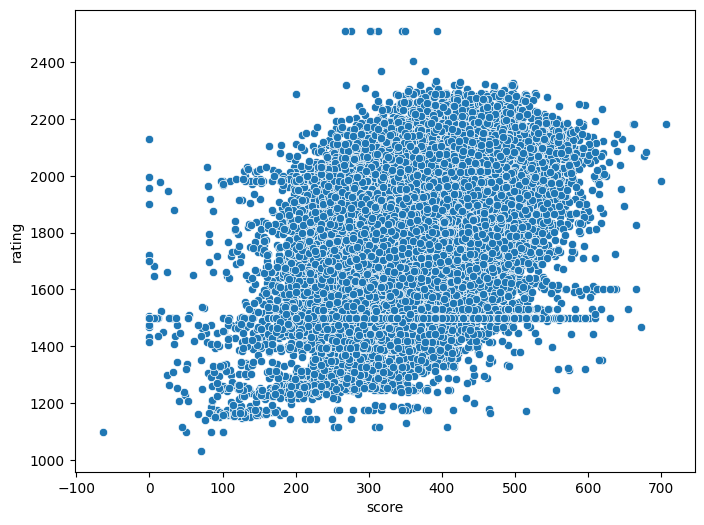

In [40]:
fig, ax = plt.subplots(figsize =(8,6))

sns.scatterplot(data = human_players, x = 'score', y='rating', ax=ax)
plt.show()

There is a slight positive correlation but the data seem to be too spread out. 

Since the rating is the rating for player **before** the current game is played, would the players previous rating or even score help us in predicting the current score?

The idea here is to create a function to produce the feature: previous_stats that will give us the rating summary upto but not including the current game: 

In [59]:
game_id_ratings = human_players[['game_id','nickname']]

human_players["avg_player_rating"] = np.zeros(len(human_players))

for nickname in game_id_ratings.nickname.unique():
    human_players.loc[human_players["nickname"]==nickname, "avg_player_ratings"]= np.append(0, human_players[human_players["nickname"]==nickname]["rating"].expanding(min_periods=1).mean().values[:-1])

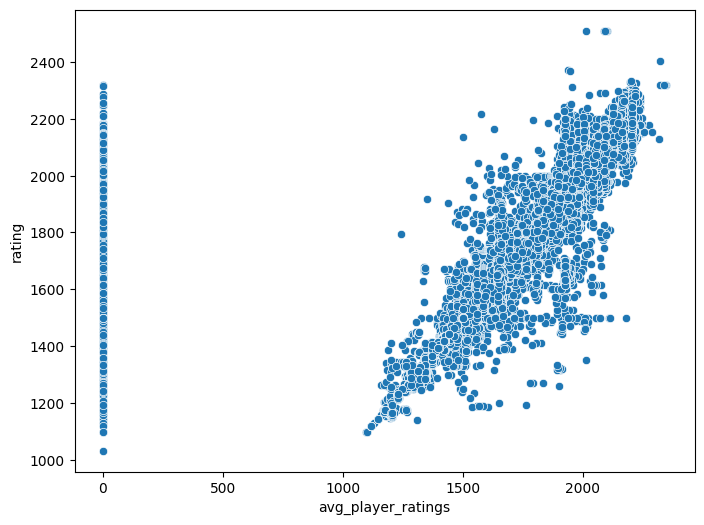

In [57]:
human_playersfig, ax = plt.subplots(figsize =(8,6))

sns.scatterplot(data = human_players, x = 'avg_player_ratings', y='rating', ax=ax)
plt.show()

There is clearly a positive correlation between the average rating of the players and the rating prior to starting the current game. So we will include this feature in our model.

Now we can start looking to see if other player statistics have similar relationship with our response variable. 